In [2]:
import numpy as np
import warnings
import os
import lambeq
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Leitura dos dados


In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

## Conversão em circuitos quânticos e criação do diagrama

Agora queremos transformar cada frase no conjunto de dados em um circuito quântico parametrizado que codifica seu significado. Começamos fazendo isso analisando as frases e gerando seus diagramas DisCoCat correspondentes.

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


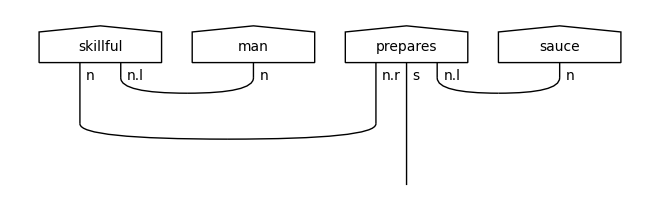

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


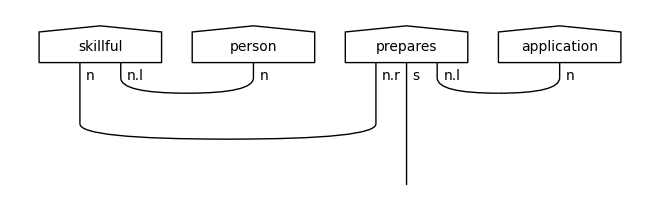

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


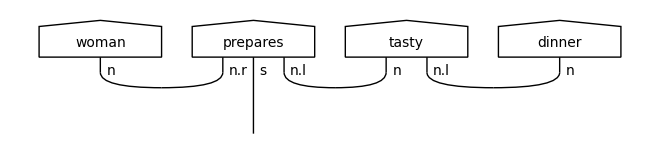

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_train_diagrams[0].draw()
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_dev_diagrams[0].draw()
raw_test_diagrams = parser.sentences2diagrams(test_data)
raw_test_diagrams[0].draw()

## Reescrevendo o Diagrama

Vamos remover todos os cups no diagrama. Essa reescrita é útil, pois significa que os circuitos quânticos com os quais acabamos no final podem ser implementados com menos qubits.

Antes de remover cups


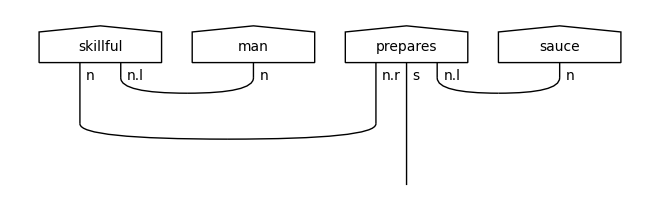

Depois de remover cups


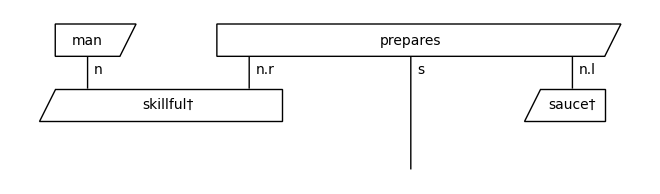

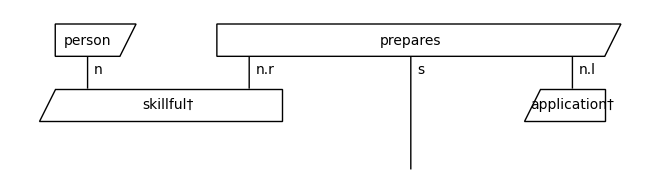

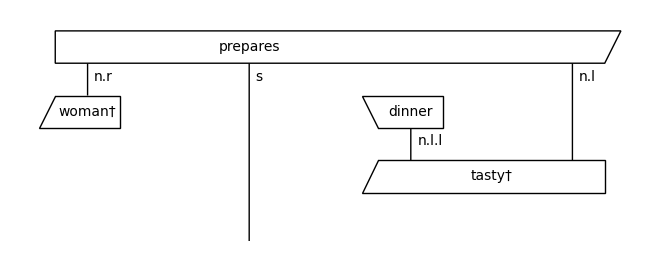

In [6]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

print("Antes de remover cups")
raw_train_diagrams[0].draw()
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
print("Depois de remover cups")
train_diagrams[0].draw()

dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
dev_diagrams[0].draw()

test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]
test_diagrams[0].draw()

## Criar o circuito quântico parametrizado 

Para criar o circuito quântico parametrizado, usaremos lambeqs IQPAnsatz.

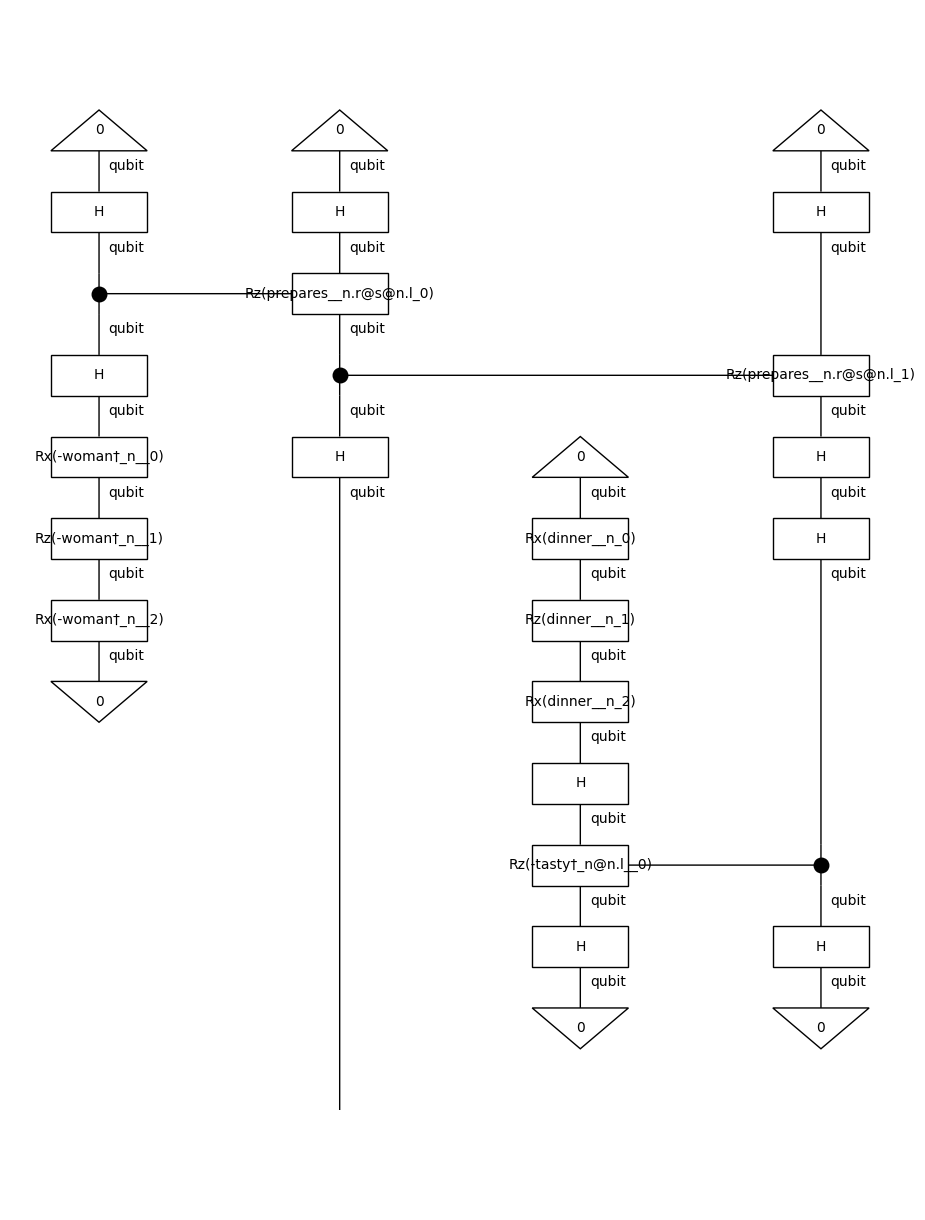

In [7]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

all_circuits = train_circuits+dev_circuits+test_circuits

test_circuits[0].draw(figsize=(9, 12))

# Configurando o Backend

In [8]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

## Criando o classificador quântico de sentenças

**OBS:** O primeiro bloco de código cria o modelo e realiza seu treinamento. Já que isso pode levar um certo tempo, há a opção de carregar diretament o modelo no segundo bloco.

In [42]:
from lambeq import TketModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

EPOCHS = 120
BATCH_SIZE = 30

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [44]:
trainer.fit(train_dataset, val_dataset,
            early_stopping_criterion='acc',
            early_stopping_interval=5,
            minimize_criterion=False)

KeyError: ResultHandle('1eb7e085-c2e4-4ba3-a3fe-06981663c5d0', 2, 4, 'null')

In [11]:
model = TketModel.from_checkpoint('checkpoint.pickle', backend_config=backend_config)

## Implementação das funções auxiliares

1. A função `_create_sentence_search_space()` não recebe entradas e retorna uma lista de todas as sentenças em nosso espaço de busca.
2. A função `_measure_quantum_circuit_for_sentence(sentence)` recebe uma sentença no espaço de busca e mede o circuito quântico parametrizado correspondente, retornando um array de dois números entre 0 e 1, que somam 1. O primeiro número representa a probabilidade de que a sentença dada seja sobre comida, enquanto o segundo número representa a probabilidade de que seja sobre TI.

In [16]:
from nltk import CFG
from nltk.parse.generate import generate

def _create_sentence_search_space():
    MC_GRAMMAR = """
      S -> NP VP
      NP -> N
      VP -> V NP
      NP -> A N
      A -> 'skillful' | 'tasty' | 'useful'
      N -> 'application' | 'dinner' | 'man' | 'meal' | 'person' | 'program' | 'sauce' | 'software' | 'woman'
      V -> 'bakes' | 'cooks' | 'debugs' | 'prepares' | 'runs'
      """

    VOCAB = ['debugs', 'dinner', 'person', 'useful', 'runs', 'program', 'bakes', 'cooks', 'skillful', 'woman', 'prepares', 'application', 'man', 'software', 'sauce', 'meal', 'tasty']

    subjects = ["man", "woman", "person"]
    objects = ["sauce", "meal", "application", "software", "dinner", "program"]

    GRAMMAR = CFG.fromstring(MC_GRAMMAR)
    SENTENCES = list(generate(GRAMMAR))

    def filter_sentence(sentence):
        # Make sure no word appears more than once:
        if not len(set(sentence)) == len(sentence):
            return False

        # Make sure subject appears before object:
        try:
            subject_position = next(i for i,v in enumerate(sentence) if v in subjects)
            object_position = next(i for i,v in enumerate(sentence) if v in objects)
        except:
            return False
        return subject_position < object_position

    SENTENCES = list(filter(filter_sentence, SENTENCES))
    return SENTENCES

def _measure_quantum_circuit_for_sentence(sentence):
    diagram = parser.sentences2diagrams([sentence +' .'])
    circ = [ansatz(d) for d in diagram]
    return model.get_diagram_output(circ)[0]

### Criação de sentenças aleatórias a partir de um tópico

In [33]:
import random
import random

SENTENCES = _create_sentence_search_space()
def randomly_generate_sentence_with_topic(topic):
    i = 0
    while i < 100:
        i += 1
        sentence = " ".join(random.choice(SENTENCES))+ ' .'
        prediction = _measure_quantum_circuit_for_sentence(sentence)
        if topic == "Food" and prediction[0] > 0.9:
            return i, sentence
        elif topic == "IT" and prediction[1] > 0.9:
            return i, sentence
    return 100, "Max iterations reached"

Let's now run the function to generate a sentence about food

In [34]:
randomly_generate_sentence_with_topic("Food")

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


KeyError: 'Unknown symbol: useful__n@n.l_0'

In [21]:
randomly_generate_sentence_with_topic("IT")

Sentence: tasty person prepares useful meal


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


KeyError: 'Unknown symbol: tasty__n@n.l_0'